# Coarse-Graining: Progress

## Two (visible) spins, coupled to a single hidden unit:

\begin{equation}
P\left(s_1,s_2,\sigma\right) = \frac{1}{Z} e^{(J_0 + J_1 s_1 + J_2 s_2)\sigma}; \mbox{  } \lbrace s_1, s_2, \sigma \rbrace=\lbrace \pm 1 \rbrace
\end{equation}


1st- and 2nd-order statistics in terms of couplings:
\begin{align*}
    \langle s_1 \rangle &= \tanh{(J_0)}\tanh{(J_1)}  \\    
    \langle s_2 \rangle &= \tanh{(J_0)}\tanh{(J_2)}  \\
    \langle s_1 s_2 \rangle &= \tanh{(J_1)}\tanh{(J_2)} 
\end{align*}

Invert to solve for couplings:
\begin{align*}
    J_0 &= \pm \tanh^{-1}{\sqrt{\frac{\langle s_1 \rangle \langle s_1 \rangle}{\langle s_1 s_2 \rangle}}} \\   
    J_1 &= \pm \tanh^{-1}{\sqrt{\frac{\langle s_1 \rangle \langle s_1 s_2 \rangle}{\langle s_2 \rangle}}}  \\ 
    J_2 &= \pm \tanh^{-1}{\sqrt{\frac{\langle s_2 \rangle \langle s_1 s_2 \rangle}{\langle s_1 \rangle}}}
\end{align*}


### Solutions are contingent on sign consistency.
While $\langle s_1 \rangle$ and $\langle s_1 \rangle$ will be negative in a neuroscience context, having $\langle s_1s_2 \rangle<0$ simultaneously is problematic.


### Are we assured that $\langle s_1 s_2 \rangle >0$?


Consider two binary random variables $x$ and $y$. Let

\begin{align*}
    P(x=1) &= p  \\
    P(y=1) &= q   \\
    P(x=1, y=1) &= r
\end{align*}

so that 

\begin{align*}
    \langle x \rangle &= (-1)P(x=-1) + (1)P(x=1) = (1-p) + p = 2p-1 \\  
   \langle y \rangle &= (-1)P(y=-1) + (1)P(y=1) = (1-q) + q = 2q-1;
\end{align*}

then we can write the expectation of $x \cdot y$ (pairwise corelation)

\begin{align*}
    \langle xy \rangle &= (-1)\left(P(x=1,y=-1) + P(x=-1,y=1)\right) + (1)\left(P(x=1,y=1)+ P(x=-1,y=-1)\right) \\
     &= (-1)\left((p-r) + (q-r)\right) + (1)\left((r)+ (1-p-q+r)\right) \\
     &= -\left(p + q -2r)\right) + \left(1-p-q+2r\right) \\
     &= 4r-2p-2q+1.
\end{align*}


Since we want $\langle xy \rangle >0$, we have

\begin{align*}
    4r-2p-2q+1 &> 0 \\
    4r &> 2p+2q-1 \\
    r &> \frac{p+q}{2} - \frac{1}{4}.
\end{align*}

That is, the parameter $r$ must be greater than the average of $p$ and $q$, minus $\frac{1}{4}$. Let $x \rightarrow s_1$ and $y \rightarrow s_2$.

In typical neuroscience applications, both parameters $p$ and $q <<0.25$ because neurons fire very sparsely.

Thus in order for $\langle s_1 s_2 \rangle >0$, we only need r to be greater than a negative number.

But this is always true for $\frac{p+q}{2}<=\frac{1}{4}$, because as a probability $r>0$ by definition.

QED

## So, the signs are consistent?

It would appear to be so; choosing the negative value for $J_0$ will result in ...

## 1. Prepare the data

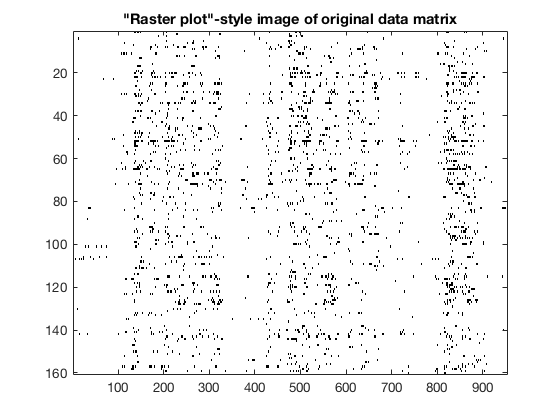

In [89]:
%CGpipeline_
close all; clear; clc; %CGpipeline_

 
%Load neural data
load bint_fishmovie32_100
data =reshape(bint(297,:,:),[160,953]);
data=data*2-1;
mean(sum(data>0,2)/953);  %Check the value of "p", how many times spiking
mean(mean(data,2));       %Check the value of <x>, the average firing rate


%CHOOSE THE NUMBER OF CG ITERATIONS !
%Number of times to apply above transformation
% Pre-allocate space for saving each GC step
CGevents=70;            %Number of iterations
C{1,CGevents+1}=[];    %Empty cell array to contain the coarsened data matrix at each step
C{1}=data;             %First element of cell array (i.e., 1st cell)--> original data matrix


%Begin a new cell array containing the "included" neuron trajectories (which will change)
for g=1:size(C{1},1)
  c{g}=C{1}(g,:);       %Break down each neuron's trajectory as member in a small cell array
end
D{1}=c;                 %Bigger cell array whose first element is "c", keeps track over iterations
E{1}=c;
%masterlist{1}=c;
incl{1}=1:length(c);
incl_origonly{1}=1:length(c);
%eliminated{1}=[];


%"Raster plot"-style image of original data matrix
figure,imagesc(C{1})
colormap(flipud(gray))
title('"Raster plot"-style image of original data matrix')


## 2. Perform the CG using analytical solution, for $CGevents$ iterations

In [90]:

for k=1:CGevents
    
    k
    
[mosthigh,hival]=find_most_highly(data);
MostHi(k,:)=mosthigh;
eliminated{k}=incl{k}(mosthigh);

v1=data(mosthigh(1),:); v2=data(mosthigh(2),:);
means=[mean(data(mosthigh(1),:)) mean(data(mosthigh(2),:))];
pairwise=mean(data(mosthigh(1),:).*data(mosthigh(2),:));
covarnce=pairwise-mean(data(mosthigh(1),:))*mean(data(mosthigh(2),:));
%[means pairwise covarnce]

%Analytical solution equations
tanhJ0sqd=means(1)*means(2)/pairwise;
tanhJ1sqd=means(1)*pairwise/means(2);
tanhJ2sqd=means(2)*pairwise/means(1);

%Choose values of couplings (interdependent, from each other)
J0=atanh(-tanhJ0sqd^.5);       %choose minus root as default
%J1=atanh(tanhJ1sqd^.5);
J1=atanh(means(1)/tanh(J0));
%J2=atanh(tanhJ2sqd^.5);
J2=atanh(pairwise/tanh(J1));
%mean(v1)^2+mean(v2)^2
%[tanhJ0sqd tanhJ1sqd tanhJ2sqd]

%Correlation for current pair -- check
corry=(pairwise-mean(v1)*mean(v2))/sqrt(var(v1)*var(v2));
[J0 J1 J2]

logistic_through         %Calculate sigma (hidden) from v1,v2; then in reverse
Meansig(k)=meansig;

newsigs{k}=samples;

%Save couplings each iteration
couplings(k,:)=[J0 J1 J2];
covthrutime(k)=covarnce;

 

%Compare probability distribution ((1,1),(1,-1),(-1,1), & (-1,-1))
%s_1 and s_2 with reconstruction for a given CG iteration
%fprintf('Individual reconstructions: sample stats')
JPD_compar(:,:,k)=[[sum((v1+v2)==2) sum((v1==1) & (v2==-1)) sum((v1==-1) & (v2==1)) sum((v1+v2)==-2)]/953; [sum((vis(1,:)+vis(2,:)==2)) sum((vis(1,:)==1) & (vis(2,:)==-1)) sum((vis(1,:)==-1) & (vis(2,:)==1)) sum((vis(1,:)+vis(2,:))==-2)]/953];
%figure
%bar(JPD_compar(:,:,k)')
%abs(JPD_compar(1,:,k)-JPD_compar(2,:,k))
%errorbar(mean(JPD_compar(:,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))

%errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))
%hold on
%errorbar(mean(JPD_compar(2,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))
 

%figure
%bar(1:4,[sum((v1+v2)==2) sum((v1==1) & (v2==-1)) sum((v1==-1) & (v2==1)) sum((v1+v2)==-2)]/953,0.5,'FaceColor',[0.2 0.2 0.5]); hold on
%bar(1:4,[sum((vis(1,:)+vis(2,:)==2)) sum((vis(1,:)==1) & (vis(2,:)==-1)) sum((vis(1,:)==-1) & (vis(2,:)==1)) sum((vis(1,:)+vis(2,:))==-2)]/953,.25,'FaceColor',[0 0.7 0.7])



%Save the coarse-grained data matrix




%size(c)


c{size(c,2)+1}=samples;

incl{k+1}=setdiff(1:length(c),cell2mat(eliminated));
%eliminated{k+1}(:)
%incl{k+1}

%c(incl{k+1})

%size(cell2mat(c(incl{k+1})'))

%size(data)
%data(mosthigh,:)=[];
%data=[data; samples];
%size(data)
data=cell2mat(c(incl{k+1})');

%sum(sum(data==cell2mat(c(incl{k+1})')))/953

end



k =

     1


ans =

   -1.1888    1.0713    1.7305


k =

     2


ans =

   -1.4444    1.1494    1.1494


k =

     3


ans =

   -1.6337    1.4620    1.3855


k =

     4


ans =

   -1.6960    1.7143    1.6293


k =

     5


ans =

   -1.6574    0.9949    2.4474


k =

     6


ans =

   -1.7324    1.7529    1.4023


k =

     7


ans =

   -1.7540    1.6285    1.5836


k =

     8


ans =

   -1.7412    1.2374    2.0171


k =

     9


ans =

   -1.7246    1.1489    1.8724


k =

    10


ans =

   -1.8130    1.5590    1.9127


k =

    11


ans =

   -1.8390    1.7509    1.5309


k =

    12


ans =

   -1.8616    1.2853    1.5067


k =

    13


ans =

   -1.9434    1.7892    1.4268


k =

    14


ans =

   -2.0241    1.6205    2.1365


k =

    15


ans =

   -2.0161    1.4908    1.5806


k =

    16


ans =

   -2.0607    1.5498    2.0254


k =

    17


ans =

   -2.0666    1.7517    1.7148


k =

    18


ans =

   -2.1323    2.2206    1.7970


k =

    19


ans =

   -2.

### Neurons included after each CG step

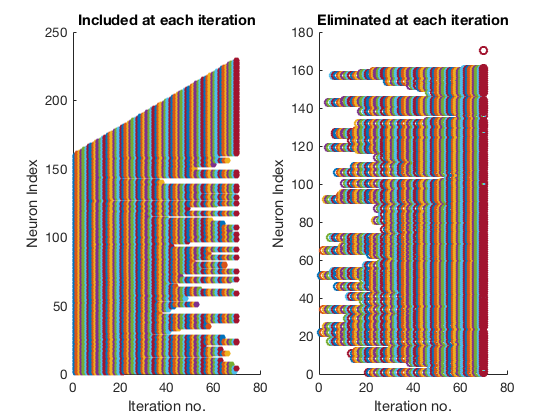

In [91]:
for k=1:CGevents

  subplot(1,2,1)
  scatter(k*ones(1,length(incl{k}(:))),incl{k}(:),25,'filled')
  hold on
  ylabel('Neuron Index')
  xlabel('Iteration no.')
  title('Included at each iteration')
  
  subplot(1,2,2)
  scatter(k*ones(1,length(cell2mat(eliminated(1:k)))),cell2mat(eliminated(1:k)))
  ylabel('Neuron Index')
  xlabel('Iteration no.')
  title('Eliminated at each iteration')
  hold on
  
  
end

## 3. Reconstruct the data by using analytical solutions backwards for each (saved) step

In [ ]:
r=c;

for k=CGevents:-1:1
    
k
eliminated{k}

activ=[r{160+k}; r{160+k}].*couplings(k,2:3)';
recons=(exp((activ))./(2.*cosh(activ))>rand(2,num_samps))*2-1;
r(eliminated{k})={recons(1,:),recons(2,:)}

%sum((sum(cell2mat(c')==cell2mat(r'),2)/953)<1)

end

figure
imagesc(cell2mat(c(1:160)')==cell2mat(r(1:160)'))
title('Entries that differ between data and final reconstruction')

%Pick k, see how reconst elements differ from originals
%imagesc(cell2mat(r(incl{k})')==cell2mat(c(incl{k})'))

## 4. Compute correlation/covariance matrixes:

### Are the most highly correlated neurons the same in original, coarsened, and reconstructed matrices?

(Need to define "receptive fields" more precisely.)


### Covariance $\mbox{ } cov(s_1,s_2) = \langle s_2 s_2 \rangle - \langle s_1 \rangle  \langle s_2 \rangle $

In [ ]:
%Compute the covariance matrixes:
        
    %[covC_raw,covC]=cov_matrix(C{1});
    [covDat_raw,covDat]=cov_matrix(cell2mat(c(incl{1})'));
    [covRec_raw,covRec]=cov_matrix(cell2mat(r(incl{1})'));
    [covCG_raw,covCG]=cov_matrix(cell2mat(c(incl{end})'));
    
    %figure,imagesc(covC); title('Original Data Matrix')
    figure,imagesc(covDat); title('Original Data'); colormap(flipud(gray)); colorbar
    figure,imagesc(covRec); title('Reconstructed Data'); colormap(flipud(gray)); colorbar
    figure,imagesc(covCG); title('Coarse-Grained Data'); colormap(flipud(gray)); colorbar
    xlim([0 160]); ylim([0 160])

## 5. Sanity check: Which are the most correlated pairs?

In [ ]:
%Find the locations of the most highly correlated in original data, coarse-grained, and final reconstructions, in order.
    
    howmanytop=10;  %Top __ covariance entries (in data/recons)
    
    [covDat_unique indD]=sort(unique(covDat(~isnan(covDat))),'descend');
    covDat_top=covDat_unique(1:howmanytop);
    [rD,cD]=find(ismember(triu(covDat),covDat_top(1:howmanytop)));
    
    [covRec_unique]=sort(unique(covRec(~isnan(covRec))),'descend');
    covRec_top=covRec_unique(1:howmanytop);
    [rR,cR]=find(ismember(triu(covRec),covRec_unique(1:howmanytop)));

    
    %Lists of top entries and locations
    
    for topindsD=1:howmanytop
        topsD(topindsD)=covDat(rD(topindsD),cD(topindsD));
    end
        [topsD,indsD]=sort(topsD','descend');
        rD=rD(indsD); cD=cD(indsD);
    
    for topindsR=1:howmanytop
        topsR(topindsR)=covDat(rR(topindsR),cR(topindsR));
    end
        [topsR,indsR]=sort(topsR','descend');
        rR=rR(indsR); cR=cR(indsR);
    
    
         
    %Side-by-side plot of top cov's for original data vs. recons
    figure
    subplot(1,2,1)
    imagesc(covDat>=covDat_top(end)); colormap(flipud(gray));
    title('Original Data')
    subplot(1,2,2)
    imagesc(covRec>=covRec_top(end)); colormap(flipud(gray));
    title('Reconstructed Data')
    %Should add covCG!!!
    
    
    %figure,imagesc(covRec>=covRec_top(end) == covDat>=covDat_top(end)); colormap(flipud(gray));
    figure,imagesc(((covRec>=covRec_top(end)) + (covDat>=covDat_top(end)))==2); colormap(flipud(gray));
    title('Elements in "Top 10" covariances for both Data/Reconstruction')

## 6. Average reconstruction error for JPD over {(1,1) (1,-1) (-1,1) (-1,-1)}
### View any value of $k$ from $1:CGevents$, or multiple on same plot

In [ ]:
k=1;
%Joint probability distributions w/ error bars showing the mean difference between reconstruction and original data
bar(mean(JPD_compar(1,:,k),3),0.5,'FaceColor',[0.2 0.2 0.5]); hold on; bar(mean(JPD_compar(2,:,k),3),.25,'FaceColor',[0 0.7 0.7])
errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3),'LineStyle','none','MarkerSize', 20)

## Questions

	
* ### What next to quantitatively measure reconstruction quality?

    * 3rd-order stats?
    * Mutual Information
    * Look at Leenoy's work
	
* ### One pair at a time -- still good? How arrange network "layers"?


### Mutual Information

In [ ]:
for m=1:160

for n=1:160

[Au,~,ic] = unique(C{1}([m n],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(C{1}([m],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(C{1}([n],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz));


for k=1:size(JPD,1)
PX_givenY(k,:)=JPD(k,:)./sum(JPD(k,:));
end

for l=1:size(JPD,2)
PY_givenX(:,l)=JPD(:,l)./sum(JPD(:,l));
end


P_X=sum(JPD,1);
H_X=sum(-P_X.*log2(P_X));

P_Y=sum(JPD,2);
H_Y=sum(-P_Y.*log2(P_Y));


intermed_X_givenY=-log2(PX_givenY);
intermed_X_givenY(isnan(intermed_X_givenY))=0;
intermed_X_givenY(isinf(intermed_X_givenY))=0;
intermed_X_givenY=PX_givenY.*intermed_X_givenY;

H_X_givenY=sum(sum(intermed_X_givenY,2).*P_Y);


intermed_Y_givenX=-log2(PY_givenX);
intermed_Y_givenX(isnan(intermed_Y_givenX))=0;
intermed_Y_givenX(isinf(intermed_Y_givenX))=0;
intermed_Y_givenX=PY_givenX.*intermed_Y_givenX;

H_Y_givenX=sum(sum(intermed_Y_givenX,1).*P_X);


MI_Dat(m,n)=H_X-H_X_givenY;
%MI=H_Y-H_Y_givenX


end

end

In [ ]:
sum(C{1}(146,:))

In [ ]:
Recmat=cell2mat(r(incl{1})');

for m=1:160

for n=1:160

[Au,~,ic] = unique(Recmat([m n],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(Recmat([m],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(Recmat([n],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz));


for k=1:size(JPD,1)
PX_givenY(k,:)=JPD(k,:)./sum(JPD(k,:));
end

for l=1:size(JPD,2)
PY_givenX(:,l)=JPD(:,l)./sum(JPD(:,l));
end


P_X=sum(JPD,1);
H_X=sum(-P_X.*log2(P_X));

P_Y=sum(JPD,2);
H_Y=sum(-P_Y.*log2(P_Y));


intermed_X_givenY=-log2(PX_givenY);
intermed_X_givenY(isnan(intermed_X_givenY))=0;
intermed_X_givenY(isinf(intermed_X_givenY))=0;
intermed_X_givenY=PX_givenY.*intermed_X_givenY;

H_X_givenY=sum(sum(intermed_X_givenY,2).*P_Y);


intermed_Y_givenX=-log2(PY_givenX);
intermed_Y_givenX(isnan(intermed_Y_givenX))=0;
intermed_Y_givenX(isinf(intermed_Y_givenX))=0;
intermed_Y_givenX=PY_givenX.*intermed_Y_givenX;

H_Y_givenX=sum(sum(intermed_Y_givenX,1).*P_X);


MI_Rec(m,n)=H_X-H_X_givenY;
%MI=H_Y-H_Y_givenX


end

end

In [ ]:
figure,imagesc(MI_Dat); title('MI: Data'); colormap(gray); colorbar
figure,imagesc(MI_Rec); title('MI: Recon'); colormap(gray); colorbar

figure,scatter(MI_Dat(:),MI_Rec(:))
hold on
linfit=polyfit(MI_Dat(:),MI_Rec(:),1);
yfitvals=polyval(linfit,MI_Dat(:));
plot(MI_Dat(:),yfitvals);
plot(MI_Dat(:),MI_Dat(:),'k')
hold off

In [ ]:
figure,imagesc(MI_Dat); title('MI: Data'); colorbar
figure,imagesc(MI_Rec); title('MI: Recon'); colorbar

figure,scatter(MI_Dat(:),MI_Rec(:))
hold on
linfit=polyfit(MI_Dat(:),MI_Rec(:),1);
yfitvals=polyval(linfit,MI_Dat(:));
plot(MI_Dat(:),yfitvals);
plot(MI_Dat(:),MI_Dat(:),'k')
hold off

In [ ]:
figure,plot(MI_Dat(:)-MI_Rec(:))
figure,hist(MI_Dat(:)-MI_Rec(:))
figure,histogram(MI_Dat(:)-MI_Rec(:),'Normalization','probability')

In [42]:
[mean(MI_Dat(:)) mean(MI_Rec(:))]


ans =

    0.0036    0.0018



In [74]:
%save('top4inboth_70iter')

In [28]:
ae=rand(10,2)
ae>[.1 .2 .3 .4 .5 .6 .7 .8 .9 1]'


ae =

    0.8695    0.2096
    0.8284    0.2724
    0.6668    0.4661
    0.2471    0.5231
    0.0303    0.8919
    0.9595    0.0848
    0.2026    0.9470
    0.8312    0.5893
    0.7416    0.3283
    0.6978    0.3026


ans =

  10x2 logical array

   1   1
   1   1
   1   1
   0   1
   0   1
   1   0
   0   1
   1   0
   0   0
   0   0



1

In [44]:
ba=rand(160,953);
ba=2*(ba<sum(C{1}>0,2)/953)-1;

In [45]:

for m=1:160

for n=1:160

[Au,~,ic] = unique(ba([m n],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(ba([m],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(ba([n],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz));


for k=1:size(JPD,1)
PX_givenY(k,:)=JPD(k,:)./sum(JPD(k,:));
end

for l=1:size(JPD,2)
PY_givenX(:,l)=JPD(:,l)./sum(JPD(:,l));
end


P_X=sum(JPD,1);
H_X=sum(-P_X.*log2(P_X));

P_Y=sum(JPD,2);
H_Y=sum(-P_Y.*log2(P_Y));


intermed_X_givenY=-log2(PX_givenY);
intermed_X_givenY(isnan(intermed_X_givenY))=0;
intermed_X_givenY(isinf(intermed_X_givenY))=0;
intermed_X_givenY=PX_givenY.*intermed_X_givenY;

H_X_givenY=sum(sum(intermed_X_givenY,2).*P_Y);


intermed_Y_givenX=-log2(PY_givenX);
intermed_Y_givenX(isnan(intermed_Y_givenX))=0;
intermed_Y_givenX(isinf(intermed_Y_givenX))=0;
intermed_Y_givenX=PY_givenX.*intermed_Y_givenX;

H_Y_givenX=sum(sum(intermed_Y_givenX,1).*P_X);


MI_ba(m,n)=H_X-H_X_givenY;
%MI=H_Y-H_Y_givenX


end

end

In [46]:
size(ba)
size(MI_ba)


ans =

   160   953


ans =

   160   160



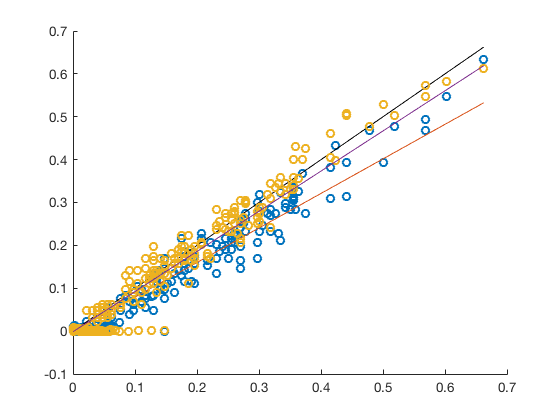

In [47]:
figure,scatter(MI_Dat(:),MI_Rec(:))
hold on
linfit=polyfit(MI_Dat(:),MI_Rec(:),1);
yfitvals=polyval(linfit,MI_Dat(:));
plot(MI_Dat(:),yfitvals);
plot(MI_Dat(:),MI_Dat(:),'k')

scatter(MI_Dat(:),MI_ba(:))
linfit_ba=polyfit(MI_Dat(:),MI_ba(:),1);
yfitvals_ba=polyval(linfit_ba,MI_Dat(:));
plot(MI_Dat(:),yfitvals_ba);
hold off

In [48]:
ba(1,:)
sum(ba(1,:)>0)


ans =

  Columns 1 through 13

    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 14 through 26

    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 27 through 39

     1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 40 through 52

    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1     1

  Columns 53 through 65

     1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 66 through 78

    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 79 through 91

    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1     1

  Columns 92 through 104

    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 105 through 117

    -1    -1     1    -1     1    -1    -1    -1    -1    -1    -1    -1    -1

  Columns 118 through 130

    -1    -1    -1

In [49]:
32/953


ans =

    0.0336




ans =

   -0.9182   -0.9244
   -0.9601   -0.9769
   -0.9769   -0.9706
   -0.9601   -0.9643
   -0.9664   -0.9685
   -0.9580   -0.9538
   -0.9622   -0.9580
   -0.8846   -0.8720
   -0.8909   -0.9035
   -0.9916   -0.9874
   -0.9140   -0.8930
   -0.9349   -0.9349
   -0.9496   -0.9454
   -0.9874   -0.9895
   -0.9895   -0.9895
   -0.9643   -0.9664
   -0.9244   -0.9161
   -0.9832   -0.9748
   -0.9601   -0.9622
   -0.7775   -0.7671
   -0.9182   -0.9014
   -0.7608   -0.7796
   -0.9475   -0.9643
   -0.9916   -0.9874
   -0.7754   -0.8174
   -0.9349   -0.9077
   -0.9853   -0.9853
   -0.9643   -0.9559
   -0.8237   -0.8636
   -0.8720   -0.8783
   -0.9517   -0.9643
   -0.9496   -0.9391
   -0.9035   -0.9119
   -0.7293   -0.7314
   -0.9706   -0.9727
   -0.9391   -0.9643
   -0.9161   -0.9077
   -0.9098   -0.9182
   -0.9622   -0.9601
   -0.9098   -0.9056
   -0.8258   -0.8552
   -0.9937   -0.9916
   -0.9056   -0.9119
   -0.9517   -0.9412
   -0.9056   -0.8930
   -0.9161   -0.9077
   -0.9538   -0.9517
   -0

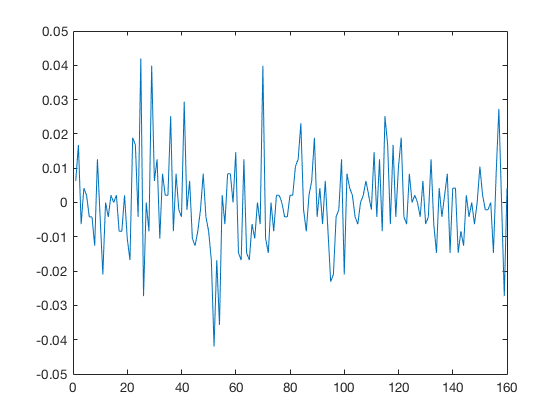

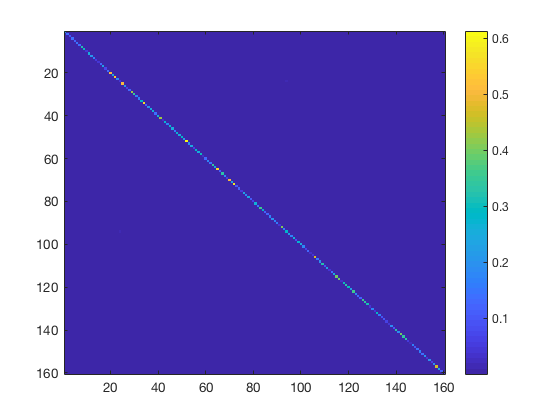

In [50]:
[mean(ba,2) mean(C{1},2)]
figure,imagesc(MI_ba); colorbar
figure,plot(mean(ba,2)- mean(C{1},2))

In [51]:
MI_ba


MI_ba =

  Columns 1 through 7

    0.2465    0.0012    0.0007    0.0000    0.0015    0.0013    0.0011
    0.0012    0.1411    0.0003    0.0006    0.0005    0.0005    0.0030
    0.0007    0.0003    0.0909    0.0003    0.0003    0.0004    0.0013
    0.0000    0.0006    0.0003    0.1411    0.0005    0.0006    0.0006
    0.0015    0.0005    0.0003    0.0005    0.1230    0.0005    0.0005
    0.0013    0.0005    0.0004    0.0006    0.0005    0.1469    0.0006
    0.0011    0.0030    0.0013    0.0006    0.0005    0.0006    0.1351
    0.0007    0.0000    0.0001    0.0005    0.0015    0.0017    0.0000
    0.0006    0.0000    0.0017    0.0000    0.0014    0.0000    0.0045
    0.0003    0.0001    0.0001    0.0001    0.0001    0.0026    0.0001
    0.0003    0.0010    0.0004    0.0000    0.0001    0.0013    0.0000
    0.0003    0.0002    0.0006    0.0002    0.0020    0.0010    0.0002
    0.0015    0.0007    0.0009    0.0003    0.0006    0.0021    0.0007
    0.0004    0.0002    0.0001    0.0002    

In [52]:
2^.1


ans =

    1.0718



In [53]:
ca=rand(160,953);
ca=2*(ca<sum(Recmat>0,2)/953)-1;


for m=1:160

for n=1:160

[Au,~,ic] = unique(ca([m n],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(ca([m],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(ca([n],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz));


for k=1:size(JPD,1)
PX_givenY(k,:)=JPD(k,:)./sum(JPD(k,:));
end

for l=1:size(JPD,2)
PY_givenX(:,l)=JPD(:,l)./sum(JPD(:,l));
end


P_X=sum(JPD,1);
H_X=sum(-P_X.*log2(P_X));

P_Y=sum(JPD,2);
H_Y=sum(-P_Y.*log2(P_Y));


intermed_X_givenY=-log2(PX_givenY);
intermed_X_givenY(isnan(intermed_X_givenY))=0;
intermed_X_givenY(isinf(intermed_X_givenY))=0;
intermed_X_givenY=PX_givenY.*intermed_X_givenY;

H_X_givenY=sum(sum(intermed_X_givenY,2).*P_Y);


intermed_Y_givenX=-log2(PY_givenX);
intermed_Y_givenX(isnan(intermed_Y_givenX))=0;
intermed_Y_givenX(isinf(intermed_Y_givenX))=0;
intermed_Y_givenX=PY_givenX.*intermed_Y_givenX;

H_Y_givenX=sum(sum(intermed_Y_givenX,1).*P_X);


MI_ca(m,n)=H_X-H_X_givenY;
%MI=H_Y-H_Y_givenX


end

end

In [54]:
[sum(C{1}>0,2) sum(Recmat>0,2)]


ans =

    36    30
    11     4
    14     8
    17    17
    15     6
    22    15
    20    24
    61    48
    46    42
     6     7
    51    46
    31    33
    26    19
     5     0
     5     6
    16    16
    40    24
    12     8
    18    15
   111    98
    47    39
   105    74
    17    17
     6     6
    87    54
    44    29
     7     4
    21    14
    65    47
    58    35
    17     5
    29    26
    42    31
   128    95
    13    13
    17    18
    44    41
    39    33
    19    19
    45    40
    69    45
     4     4
    42    34
    28    23
    51    36
    44    20
    23    18
    41    28
    42    45
    52    39
    43    34
   164   152
    33    23
    55    36
     6     3
    51    55
    37    27
    46    45
     3     3
    10    10
    33    21
    29    25
    55    47
    50    51
   128   103
    17    10
    63    47
    28    15
     9     9
    87    74
    41    33
   140   120
    12     5
    19    12
     5     5
    36    24
    

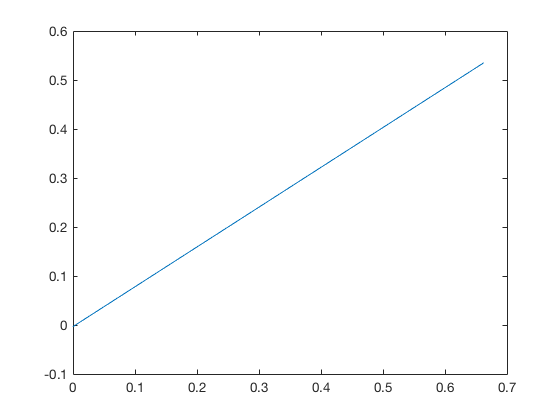

In [55]:
figure,scatter(MI_Dat(:),MI_Rec(:))
hold on
linfit=polyfit(MI_Dat(:),MI_Rec(:),1);
yfitvals=polyval(linfit,MI_Dat(:));
plot(MI_Dat(:),yfitvals);
plot(MI_Dat(:),MI_Dat(:),'k')


scatter(MI_Dat(:),MI_ba(:))
linfit_ba=polyfit(MI_Dat(:),MI_ba(:),1);
yfitvals_ba=polyval(linfit_ba,MI_Dat(:));
plot(MI_Dat(:),yfitvals_ba);
hold off

scatter(MI_Dat(:),MI_ca(:))
linfit_ca=polyfit(MI_Dat(:),MI_ca(:),1);
yfitvals_ca=polyval(linfit_ca,MI_Dat(:));
plot(MI_Dat(:),yfitvals_ca);
hold off

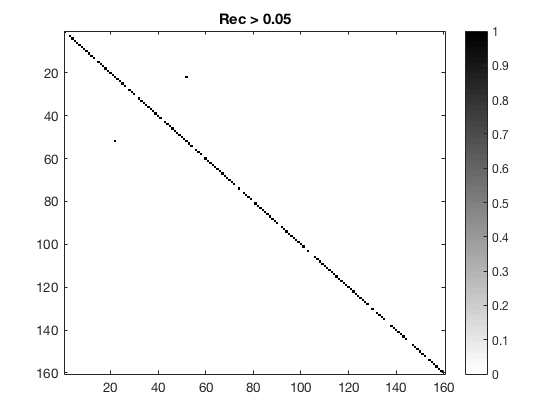

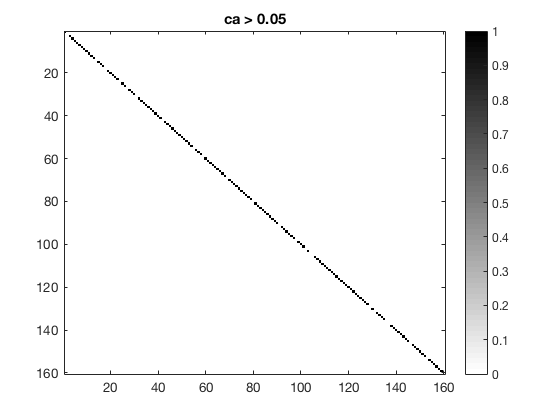

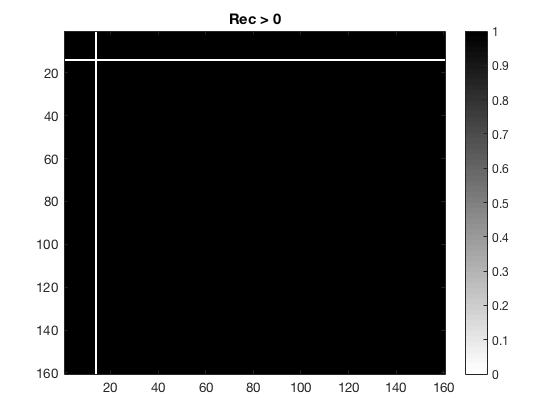

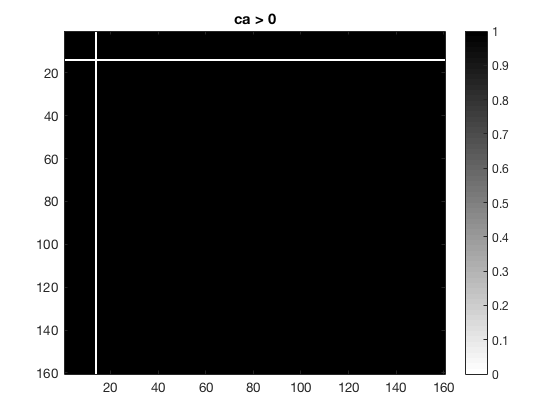

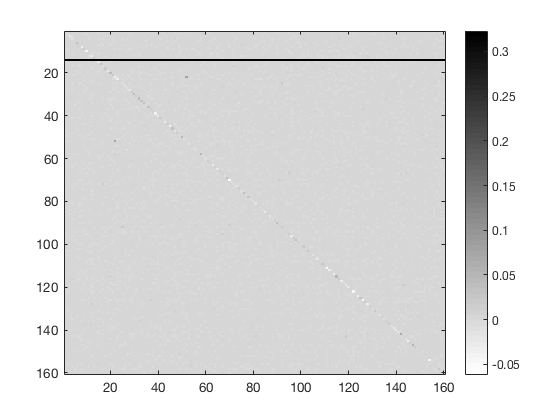

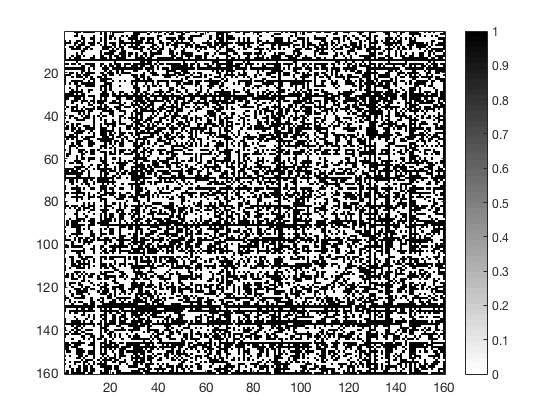

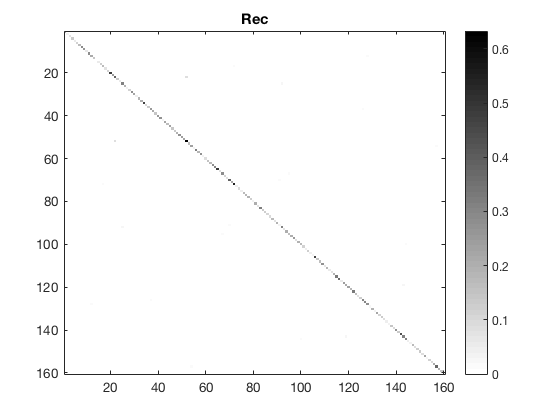

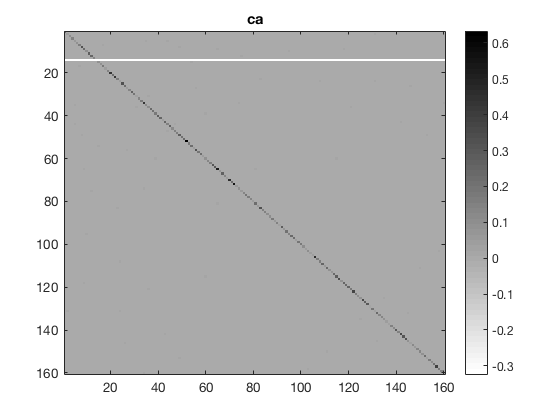

In [56]:
figure,imagesc(MI_ca); colorbar; colormap(flipud(gray)); title('ca')
figure,imagesc(MI_Rec); colorbar; colormap(flipud(gray)); title('Rec')
figure,imagesc(MI_Rec>MI_ca);colorbar; colormap(flipud(gray))
figure,imagesc(MI_Rec-MI_ca);colorbar; colormap(flipud(gray))

figure,imagesc(MI_ca>0); colorbar; colormap(flipud(gray)); title('ca > 0')
figure,imagesc(MI_Rec>0); colorbar; colormap(flipud(gray)); title('Rec > 0')

figure,imagesc(MI_ca>0.05); colorbar; colormap(flipud(gray)); title('ca > 0.05')
figure,imagesc(MI_Rec>0.05); colorbar; colormap(flipud(gray)); title('Rec > 0.05')

### Effective receptive fields (by convolving the weight matrices in succeeding layers)
Check that each is reproducible...

### Then repeat Leenoy's method by summing? then draw the graph representation, 2 edges =1 and sum

In [61]:
2.^[1 2 3 4 5 6]


ans =

     2     4     8    16    32    64



In [67]:
sum(sum(C{1}))/prod(size(C{1}))
mean(mean(C{1}))


ans =

   -0.9272


ans =

   -0.9272



In [69]:
mean(mean(cell2mat(D{1}')))


ans =

   -0.9272



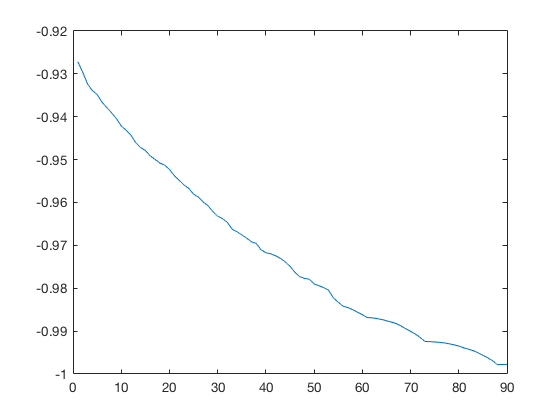

In [18]:
for oo=1:CGevents

    meanact(oo)=mean(mean(cell2mat(D{oo}')));
    
end

plot(meanact)

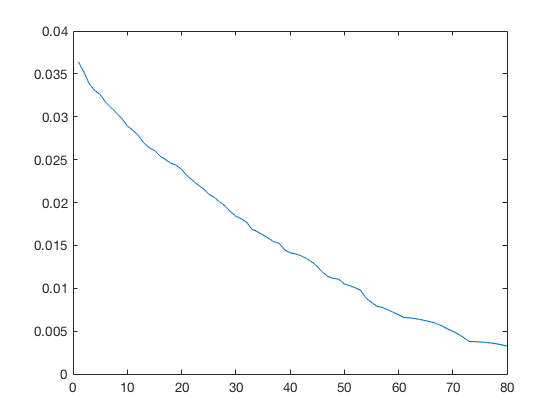

In [12]:
for oo=1:CGevents

    meanact(oo)=mean(mean( 0.5* (1+  cell2mat(D{oo}') )  ));
    
end

plot(meanact)

None of this will work exactly like hers. But should I try do this like Leenoy?  Divide network in half each time? Top... 50% correl's?

In [83]:
couplings(1,:)
couplings(2,:)
conv(couplings(1,:),couplings(2,:))
conv(couplings(2,:),couplings(1,:))
conv2(couplings(1,:),couplings(2,:))


ans =

   -1.1888    1.0713    1.7305


ans =

   -1.4444    1.1494    1.1494


ans =

    1.7170   -2.9138   -2.6344    3.2205    1.9891


ans =

    1.7170   -2.9138   -2.6344    3.2205    1.9891


ans =

    1.7170   -2.9138   -2.6344    3.2205    1.9891



In [12]:
%(-p(2)*log2(p(2)) - (1-p(2))*log2(1-p(2))) 
%(-p(1)*log2(p(1)) - (1-p(1))*log2(1-p(1))) 

Error using eval
Undefined function or variable 'p'.



In [13]:
k=1; l=2;
fprintf('       1 1,    1 -1,    -1 1,    -1 -1')
jpd=[sum(ismember(C{1}([k l],:)',[ 1  1],'rows')) sum(ismember(C{1}([k l],:)',[ 1 -1],'rows')) sum(ismember(C{1}([k l],:)',[-1  1],'rows')) sum(ismember(C{1}([k l],:)',[-1 -1],'rows'))]/953
h_joint=sum((-jpd(jpd~=0).*log2(jpd(jpd~=0))))
2.^h_joint

p=sum(C{1}([k l],:)>0,2)/953
%q=1-p

%s_cond = -   ( jpd(3)*log10(jpd(3)/q(1))   + jpd(2)*log10(jpd(2)/p(1)) + jpd(4)*log10(jpd(4)/q(1))  )
%s_cond_alt = -   (  jpd(2)*log10(jpd(2)/q(2))  + jpd(3)*log10(jpd(2)/p(2)) + jpd(4)*log10(jpd(4)/q(2))  )

h_cond__s1_given_s2 = h_joint - (-p(1)*log2(p(1)) - (1-p(1))*log2(1-p(1))) 
h_cond__s2_given_s1 = h_joint - (-p(2)*log2(p(2)) - (1-p(2))*log2(1-p(2))) 

MI = h_joint - h_cond__s1_given_s2 - h_cond__s2_given_s1

2.^MI

covDat(1,2)

       1 1,    1 -1,    -1 1,    -1 -1
jpd =

         0    0.0378    0.0115    0.9507


h_joint =

    0.3222


ans =

    1.2502


p =

    0.0378
    0.0115


h_cond__s1_given_s2 =

    0.0902


h_cond__s2_given_s1 =

    0.2314


MI =

   6.4504e-04


ans =

    1.0004


ans =

   -0.0017



In [14]:
Recmat=cell2mat(R{1}');
k=1; l=2;
fprintf('       1 1,    1 -1,    -1 1,    -1 -1')
jpd=[sum(ismember(Recmat([k l],:)',[ 1  1],'rows')) sum(ismember(Recmat([k l],:)',[ 1 -1],'rows')) sum(ismember(Recmat([k l],:)',[-1  1],'rows')) sum(ismember(Recmat([k l],:)',[-1 -1],'rows'))]/953
h_joint=sum((-jpd(jpd~=0).*log2(jpd(jpd~=0))))
2.^h_joint

p=sum(C{1}([k l],:)>0,2)/953
%q=1-p

%s_cond = -   ( jpd(3)*log10(jpd(3)/q(1))   + jpd(2)*log10(jpd(2)/p(1)) + jpd(4)*log10(jpd(4)/q(1))  )
%s_cond_alt = -   (  jpd(2)*log10(jpd(2)/q(2))  + jpd(3)*log10(jpd(2)/p(2)) + jpd(4)*log10(jpd(4)/q(2))  )

h_cond__s1_given_s2 = h_joint - (-p(1)*log2(p(1)) - (1-p(1))*log2(1-p(1))) 
h_cond__s2_given_s1 = h_joint - (-p(2)*log2(p(2)) - (1-p(2))*log2(1-p(2))) 

MI = h_joint - h_cond__s1_given_s2 - h_cond__s2_given_s1

2.^MI

covDat(1,2)

       1 1,    1 -1,    -1 1,    -1 -1
jpd =

         0    0.0378    0.0115    0.9507


h_joint =

    0.3222


ans =

    1.2502


p =

    0.0378
    0.0115


h_cond__s1_given_s2 =

    0.0902


h_cond__s2_given_s1 =

    0.2314


MI =

   6.4504e-04


ans =

    1.0004


ans =

   -0.0017



In [34]:
1


ans =

     1



In [35]:
for k=1:160

for l=1:160

%fprintf('       1 1,    1 -1,    -1 1,    -1 -1')
jpd=[sum(ismember(C{1}([k l],:)',[ 1  1],'rows')) sum(ismember(C{1}([k l],:)',[ 1 -1],'rows')) sum(ismember(C{1}([k l],:)',[-1  1],'rows')) sum(ismember(C{1}([k l],:)',[-1 -1],'rows'))]/953;
h_joint=sum((-jpd(jpd~=0).*log2(jpd(jpd~=0))));
2.^h_joint;

p=sum(C{1}([k l],:)>0,2)/953;

h_cond__s1_given_s2 = h_joint - (-p(1)*log2(p(1)) - (1-p(1))*log2(1-p(1))) ;
h_cond__s2_given_s1 = h_joint - (-p(2)*log2(p(2)) - (1-p(2))*log2(1-p(2))) ;

MI_data(k,l) = h_joint - h_cond__s1_given_s2 - h_cond__s2_given_s1;

end 
end


In [36]:
[MI_data(17:30)'- MI_rec(17:30)']


ans =

   -0.0584
         0
         0
         0
         0
   -0.0823
         0
         0
   -0.0241
         0
         0
         0
         0
         0



In [37]:
sum((sum(MI_data~=MI_rec)))

Matrix dimensions must agree.



In [38]:
sum((sum(covDat~=covRec)))


ans =

        3250



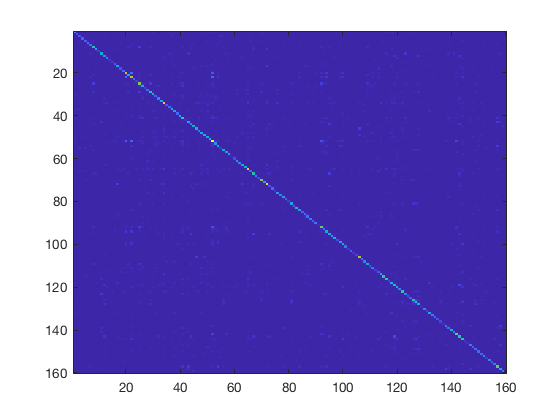

In [39]:
imagesc(MI_data)

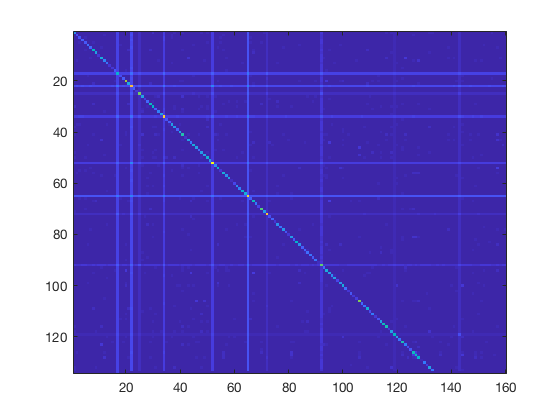

In [40]:
imagesc(MI_rec)

In [41]:
MI_rec(1:26,1:2)


ans =

    0.2320    0.0006
    0.0006    0.0909
    0.0046    0.0016
    0.0010    0.0003
    0.0043    0.0051
    0.0000    0.0039
    0.0001    0.0004
    0.0036    0.0014
    0.0018    0.0008
    0.0012    0.0001
    0.0029    0.0009
    0.0036    0.0153
    0.0022    0.0008
    0.0003    0.0001
    0.0003    0.0031
    0.0009    0.0003
    0.0707    0.0715
    0.0024    0.0058
    0.0036    0.0003
    0.0116    0.0003
    0.0034    0.0003
    0.0884    0.0908
    0.0010    0.0013
    0.0012    0.0001
    0.0285    0.0299
    0.0084    0.0021



In [42]:
Recmat=cell2mat(R{1}');

for k=1:160
for l=1:160

%fprintf('       1 1,    1 -1,    -1 1,    -1 -1')
jpd=[sum(ismember(Recmat([k l],:)',[ 1  1],'rows')) sum(ismember(Recmat([k l],:)',[ 1 -1],'rows')) sum(ismember(Recmat([k l],:)',[-1  1],'rows')) sum(ismember(Recmat([k l],:)',[-1 -1],'rows'))]/953;
h_joint=sum((-jpd(jpd~=0).*log2(jpd(jpd~=0))));
2.^h_joint;

p=sum(C{1}([k l],:)>0,2)/953;
%q=1-p

%s_cond = -   ( jpd(3)*log10(jpd(3)/q(1))   + jpd(2)*log10(jpd(2)/p(1)) + jpd(4)*log10(jpd(4)/q(1))  )
%s_cond_alt = -   (  jpd(2)*log10(jpd(2)/q(2))  + jpd(3)*log10(jpd(2)/p(2)) + jpd(4)*log10(jpd(4)/q(2))  )

h_cond__s1_given_s2 = h_joint - (-p(1)*log2(p(1)) - (1-p(1))*log2(1-p(1))) ;
h_cond__s2_given_s1 = h_joint - (-p(2)*log2(p(2)) - (1-p(2))*log2(1-p(2))) ;

MI_rec(k,l) = h_joint - h_cond__s1_given_s2 - h_cond__s2_given_s1;

end 
end


In [23]:

    k=1;
    l=2;

[Au,~,ic] = unique(C{1}([k l],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];
Result


Result =

    -1    -1   906
    -1     1    11
     1    -1    36



In [24]:

    k=1;
    l=2;

[Au,~,ic] = unique(C{1}([k l],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(C{1}([k],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(C{1}([l],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz))


JPD =

    0.9507    0.0115
    0.0378         0



In [43]:
for m=1:160

for n=1:160

[Au,~,ic] = unique(C{1}([m n],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(C{1}([m],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(C{1}([n],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz));


for k=1:size(JPD,1)
PX_givenY(k,:)=JPD(k,:)./sum(JPD(k,:));
end

for l=1:size(JPD,2)
PY_givenX(:,l)=JPD(:,l)./sum(JPD(:,l));
end


P_X=sum(JPD,1);
H_X=sum(-P_X.*log2(P_X));

P_Y=sum(JPD,2);
H_Y=sum(-P_Y.*log2(P_Y));


intermed_X_givenY=-log2(PX_givenY);
intermed_X_givenY(isnan(intermed_X_givenY))=0;
intermed_X_givenY(isinf(intermed_X_givenY))=0;
intermed_X_givenY=PX_givenY.*intermed_X_givenY;

H_X_givenY=sum(sum(intermed_X_givenY,2).*P_Y);


intermed_Y_givenX=-log2(PY_givenX);
intermed_Y_givenX(isnan(intermed_Y_givenX))=0;
intermed_Y_givenX(isinf(intermed_Y_givenX))=0;
intermed_Y_givenX=PY_givenX.*intermed_Y_givenX;

H_Y_givenX=sum(sum(intermed_Y_givenX,1).*P_X);


MI_Dat(m,n)=H_X-H_X_givenY;
%MI=H_Y-H_Y_givenX


end

end

In [26]:
[MI_data(1:10)' MI(1:10)']

Index exceeds the number of array elements (1).



In [27]:
size(MI)


ans =

     1     1



In [44]:
Recmat=cell2mat(R{1}');

for m=1:160

for n=1:160

[Au,~,ic] = unique(Recmat([m n],:)', 'rows');
tally = accumarray(ic, 1);
Result = [Au tally];



[unique_s1,~,label_s1] = unique(Recmat([m],:)', 'rows');
counts_s1 = accumarray(label_s1, 1);
[unique_s2,~,label_s2] = unique(Recmat([n],:)', 'rows');
counts_s2 = accumarray(label_s2, 1);
countz=accumarray([label_s1 label_s2],1);
JPD=countz/sum(sum(countz));


for k=1:size(JPD,1)
PX_givenY(k,:)=JPD(k,:)./sum(JPD(k,:));
end

for l=1:size(JPD,2)
PY_givenX(:,l)=JPD(:,l)./sum(JPD(:,l));
end


P_X=sum(JPD,1);
H_X=sum(-P_X.*log2(P_X));

P_Y=sum(JPD,2);
H_Y=sum(-P_Y.*log2(P_Y));


intermed_X_givenY=-log2(PX_givenY);
intermed_X_givenY(isnan(intermed_X_givenY))=0;
intermed_X_givenY(isinf(intermed_X_givenY))=0;
intermed_X_givenY=PX_givenY.*intermed_X_givenY;

H_X_givenY=sum(sum(intermed_X_givenY,2).*P_Y);


intermed_Y_givenX=-log2(PY_givenX);
intermed_Y_givenX(isnan(intermed_Y_givenX))=0;
intermed_Y_givenX(isinf(intermed_Y_givenX))=0;
intermed_Y_givenX=PY_givenX.*intermed_Y_givenX;

H_Y_givenX=sum(sum(intermed_Y_givenX,1).*P_X);


MI_Rec(m,n)=H_X-H_X_givenY;
%MI=H_Y-H_Y_givenX


end

end

In [45]:
[MI_rec(1:10)' MI(1:10)']

Index exceeds the number of array elements (1).



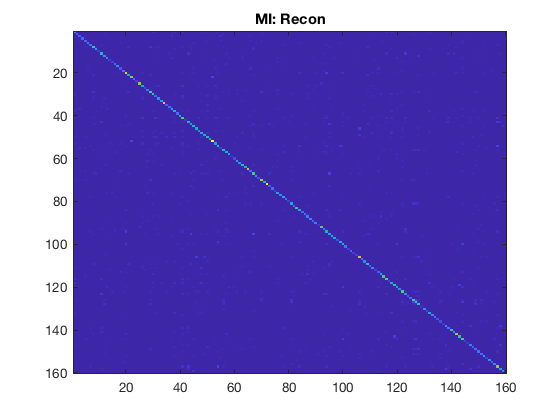

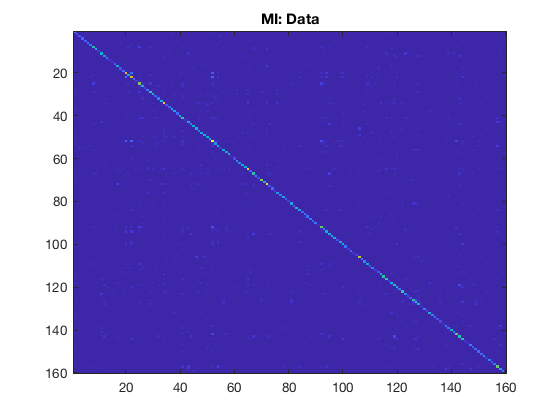

In [46]:
figure,imagesc(MI_Dat); title('MI: Data')
figure,imagesc(MI_Rec); title('MI: Recon')

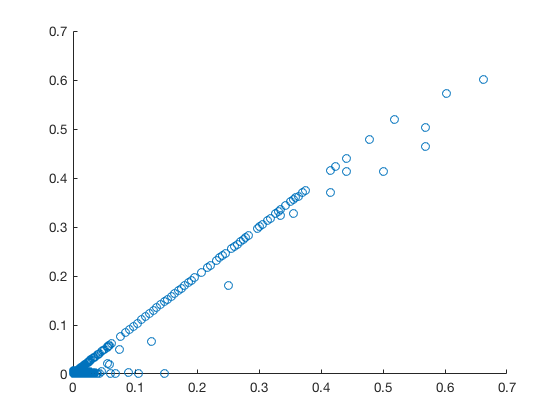

In [47]:
scatter(MI_Dat(:),MI_Rec(:))

In [48]:
 mean(MI_Dat(:)- MI_Rec(:))


ans =

   5.1930e-04



In [49]:
 var(MI_Dat(:)- MI_Rec(:))


ans =

   1.2493e-05



In [ ]:
1+1

In [ ]:
[MI(1,1) MI_dat(1,1) MI_rec(1,1) MI_Dat(1,1) MI_Rec(1,1)]

In [ ]:
%CGpipeline
%close all; clear; clc; CGpipeline

 
%Load neural data
load bint_fishmovie32_100
data=reshape(bint(297,:,:),[160,953]);
data=data*2-1;
mean(sum(data>0,2)/953);  %Check the value of "p", how many times spiking
mean(mean(data,2));       %Check the value of <x>, the average firing rate


%CHOOSE THE NUMBER OF CG ITERATIONS !
%Number of times to apply above transformation
% Pre-allocate space for saving each GC step
CGevents=90;            %Number of iterations
C{1,CGevents+1}=[];    %Empty cell array to contain the coarsened data matrix at each step
C{1}=data;             %First element of cell array (i.e., 1st cell)--> original data matrix


%Begin a new cell array containing the "included" neuron trajectories (which will change)
for g=1:size(C{1},1)
  c{g}=C{1}(g,:);       %Break down each neuron's trajectory as member in a small cell array
end
D{1}=c;                 %Bigger cell array whose first element is "c", keeps track over iterations
E{1}=c;
%masterlist{1}=c;
incl{1}=1:length(c);
incl_origonly{1}=1:length(c);


%"Raster plot"-style image of original data matrix
figure,imagesc(C{1})
colormap(flipud(gray))
title('"Raster plot"-style image of original data matrix')
